In [10]:
using Plots,BifurcationKit, LinearAlgebra,SparseArrays, Parameters, Setfield
const BK = BifurcationKit
include("CPDEox.jl")
using LaTeXStrings

# set up plot 
plot_font = "Computer Modern"
default(fontfamily=plot_font,framestyle=:box, label=nothing, grid=false,tickfont = font(10, "serif"),tick_direction=:out,thickness_scaling = 1.)



In [ ]:
function Fun(X,p)
    @unpack pmax,Gmax,vp,OpDzz,OpDxx,OpDox,par,funvp= p
    nx, nz = par["nx"], par["nz"]
    par["magnVp"]=funvp(vp)
    par["DC"]["pmax"]=pmax*1e-2
    par["CSC"]["pmax"]=pmax*1e-2*0.25

    par["max_consumption"]=Gmax*par["Dox"]
    N = reshape(X[1:end-nx],nz,nx+1)
    C=vcat(X[end-nx+1:end])
    
    return Main.CPDE.wrap_F(N,C,OpDzz,OpDxx,OpDox,par["spz"],par) 
end

function FJ(X, p)
    @unpack pmax,Gmax,vp,OpDzz,OpDxx,OpDox,par,funvp= p
    nx, nz = par["nx"], par["nz"]
    par["max_consumption"]=Gmax*par["Dox"]
    par["magnVp"]=funvp(vp)
    par["DC"]["pmax"]=pmax*1e-2
    par["CSC"]["pmax"]=pmax*1e-2*0.25

    N = reshape(X[1:end-nx],nz,nx+1)
    C=vcat(X[end-nx+1:end])

    A=Main.CPDE.wrap_Jacobian(N,C,OpDzz,OpDxx,OpDox,par["spz"],par) 
    return sparse(A)
end
function total_mass(X,nx,nz)
    N = getN(X,nx,nz)
    I=zeros(nx+1,1)
    IT=ones(nx+1)*1.0/nx
    IT[1]*= 0.5
    IT[end]*= 0.5
    for j in 1:nx+1
        I[j]=sum(N[:,j])/nz
    end
    result=IT'*I
    return result[1]
    
end
function rho_dist(X,nx,nz)
    N = getN(X,nx,nz)
    IT=ones(nx+1)*1.0/nx
    IT[1]*= 0.5
    IT[end]*= 0.5
    result=N*IT
    return result
    
end
function getN(X,nx,nz)
    return reshape(X[1:end-nx],nz,nx+1)
end
function getC(X,nx,nz)
    return append!(vcat(X[end-nx+1:end]),[1])
end
function mySave(x,p,par)
    
    N=getN(x,par["nx"],par["nz"])
    C=getC(x,par["nx"],par["nz"])

    p1=heatmap(ZZ, XX, N', aspect_ratio=:equal, fillcolor=:balance,xlims=(0,1),ylims=(0,1),xlabel="s", ylabel="x")
    p2=plot(C,XX,aspect_ratio=:equal,xlims=(0,1),ylims=(0,1),ylabel="x",xlabel="c(x)",grid=false,linewidth=2,legend=false)
   
    return plot(p1,p2)
end

mySave (generic function with 1 method)

Compute a single steady state

In [8]:
Nx=50
Nz=120
funvp1(a)=a*1e-4
funvp2(a)=10^a
dic,OpD1,OpD2,OpD3 = Main.CPDE.init_par(Nx,Nz);
par_mod = (pmax=1.,Gmax=4., vp=4.3, OpDzz=OpD1, OpDxx = OpD2, OpDox=OpD3,par = dic,funvp=funvp1);
sol0 = CPDE.formInitialGuess(dic,Nx,Nz);


In [9]:
D(f, x, p, dx) = ForwardDiff.derivative(t->f(x .+ t .* dx, p), 0.)

d1Fmit(x,p,dx1) = D((z, p0) -> Fun(z, p0), x, p, dx1)
d2Fmit(x,p,dx1,dx2) = D((z, p0) -> d1Fmit(z, p0, dx1), x, p, dx2)
d3Fmit(x,p,dx1,dx2,dx3) = D((z, p0) -> d2Fmit(z, p0, dx1, dx2), x, p, dx3)
jet=(Fun,FJ,d2Fmit,d3Fmit)


(Fun, FJ, d2Fmit, d3Fmit)

In [15]:
opt_newton = NewtonPar(tol = 1e-10, verbose = true, maxIter = 50)
out, _, _ = @time BK.newton(Fun,FJ,sol0, par_mod, opt_newton);


┌────────────────────-────────────────────────────────┐
│ Newton Iterations      f(x)      Linear Iterations  │
├─────────────┐──────────────────────┐────────────────┤
│       0     │       9.3170e+01     │        0       │
│       1     │       2.3237e+00     │        1       │
│       2     │       9.6391e-01     │        1       │
│       3     │       1.7546e+00     │        1       │
│       4     │       1.1871e+00     │        1       │
│       5     │       1.4802e-01     │        1       │
│       6     │       8.0945e-04     │        1       │
│       7     │       1.0019e-06     │        1       │
│       8     │       7.6074e-12     │        1       │
└─────────────┴──────-───────────────┴────────────────┘
  3.098245 seconds (5.68 M allocations: 4.293 GiB, 4.92% gc time)


0.63463052816187430.175578214888029445.497142913179265

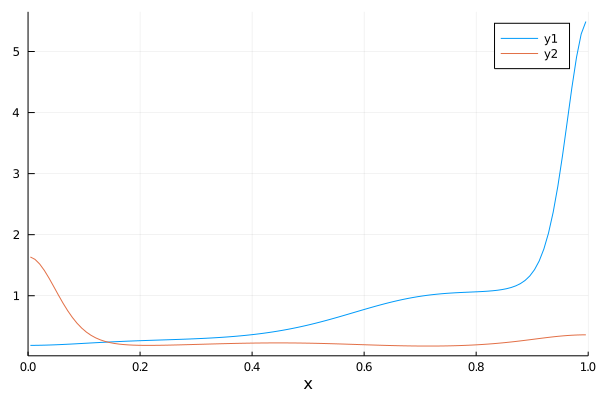

In [16]:

XX=dic["spx"]
ZZ=collect(dic["spz"][1:end-1]).+dic["spz"][2]/2
N0=getN(out,Nx,Nz)
C0=getC(out,Nx,Nz)
print(total_mass(out,Nx,Nz))
print(minimum(N0))
print(maximum(N0))
plot(ZZ,N0[:,50],xlabel="x",xlim=(0,1))
plot!(ZZ,N0[:,1])


In [151]:
opt_newton = NewtonPar(tol = 1e-10, verbose =false, maxIter = 3)

opts_br = ContinuationPar(dsmin=0.005,dsmax=0.2,ds=-0.01,pMax=10.0,pMin=0.0,detectBifurcation=2,
nev = 10, plotEveryStep = 10, newtonOptions = opt_newton,maxSteps=200,saveSolEveryStep=1,precisionStability=1e-10, 
nInversion= 4, dsminBisection = 1e-6, maxBisectionSteps = 30);
function optionsCont(x,p,l; opt0 = opts_br)
    return opt0
end
diagram1 = BK. bifurcationdiagram(jet...,
    out,par_mod,(@lens _.Gmax),3,optionsCont;
    usedeflation=true,
    printSolution = (x, p) -> total_mass(x,Nx,Nz),
    normC = x -> norm(x, Inf),
    plot = false, verbosity = 0)

##################################################
---> Automatic computation of bifurcation diagram

────────────────────────────────────────────────────────────────────────────────
--> New branch, level = 2, dim(Kernel) = 1, code = 0, from bp #1 at p = 1.9329914367788257, type = bp
- #  1,    bp at p ≈ +1.93299144 ∈ (+1.93184437, +1.93299144), |δp|=1e-03, [    guess], δ = ( 1,  0), step =  92, eigenelements in eig[ 93], ind_ev =   1


Bifurcation diagram. Root branch (level 1) has 0 children and is such that:
Branch number of points: 145
Branch of Equilibrium
Type of vectors: Array{Float64,1}
Parameters Gmax from 10.0 to 10.0
Special points:
 (ind_ev = index of the bifurcating eigenvalue e.g. `br.eig[idx].eigenvals[ind_ev]`)
- #  1,    bp at Gmax ≈ +1.93299144 ∈ (+1.93184437, +1.93299144), |δp|=1e-03, [    guess], δ = ( 1,  0), step =  92, eigenelements in eig[ 93], ind_ev =   1


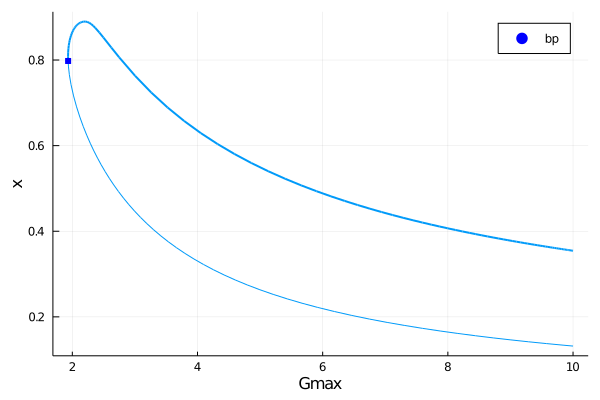

In [152]:
plot(diagram1)



In [8]:
par_mod = (pmax=1.0,Gmax=4.0, vp=-4.0, OpDzz=OpD1, OpDxx = OpD2, OpDox=OpD3,par = dic,funvp=funvp2);
opt_newton = NewtonPar(tol = 1e-10, verbose = true, maxIter = 50)
out, _, _ = @time BK.newton(Fun,FJ,sol0, par_mod, opt_newton);


┌────────────────────-────────────────────────────────┐
│ Newton Iterations      f(x)      Linear Iterations  │
├─────────────┐──────────────────────┐────────────────┤
│       0     │       9.3168e+01     │        0       │
│       1     │       2.3092e+00     │        1       │
│       2     │       6.7290e-01     │        1       │
│       3     │       9.5394e-01     │        1       │
│       4     │       2.0357e-01     │        1       │
│       5     │       5.8605e-03     │        1       │
│       6     │       1.0597e-04     │        1       │
│       7     │       9.1819e-09     │        1       │
│       8     │       6.0981e-12     │        1       │
└─────────────┴──────-───────────────┴────────────────┘
  8.152145 seconds (20.46 M allocations: 3.811 GiB, 6.62% gc time)


In [12]:
opt_newton = NewtonPar(tol = 1e-10, verbose =false, maxIter = 5)

opts_br = ContinuationPar(dsmin=0.005,dsmax=0.1,ds=0.01,pMax=-0.5,pMin=-4.0,detectBifurcation=2,
nev = 25, plotEveryStep = 10, newtonOptions = opt_newton,maxSteps=600,saveSolEveryStep=1,precisionStability=1e-10, 
nInversion= 4, dsminBisection = 1e-8, maxBisectionSteps = 30);
function optionsCont(x,p,l; opt0 = opts_br)
    return opt0
end
diagram_vp1 = BK. bifurcationdiagram(jet...,
    out,par_mod,(@lens _.vp),3,optionsCont;
    usedeflation=true,
    printSolution = (x, p) -> total_mass(x,Nx,Nz),
    normC = x -> norm(x, Inf),
    plot = false, verbosity = 0)

┌ Warning: Error in eigenvalues computation. It seems an eigenvalue is missing, probably conj(λ) for some already computed eigenvalue λ. This makes the identification (but not the detection) of bifurcation points erroneous. You should increase the number of requested eigenvalues `nev`.
└ @ BifurcationKit /home/celora/.julia/packages/BifurcationKit/Yvq7p/src/Bifurcations.jl:106
┌ Warning: Error in eigenvalues computation. It seems an eigenvalue is missing, probably conj(λ) for some already computed eigenvalue λ. This makes the identification (but not the detection) of bifurcation points erroneous. You should increase the number of requested eigenvalues `nev`.
└ @ BifurcationKit /home/celora/.julia/packages/BifurcationKit/Yvq7p/src/Bifurcations.jl:106
┌ Warning: Error in eigenvalues computation. It seems an eigenvalue is missing, probably conj(λ) for some already computed eigenvalue λ. This makes the identification (but not the detection) of bifurcation points erroneous. You should incre

InterruptException: [91mInterruptException:[39m

In [27]:
X=[]
for k in diagram_vp1.γ.branch
    append!(X,k.x)
    if k.x<0.65
        print(10^(k.param))
    end
end

0.00063078528934293210.00073339234393289390.00085079208228662320.0009863870880046350.00114476432050612980.00133213595985325710.00155673345616039570.00182864006306582330.002158111958099650.00255234025705626580.0030140565900003490.00354488904325060650.00414881999985073150.0048317042992441420.0055989876884067340.00645381590017790950.0073959352575520170.0084212972044711720.0095222720455787390.01

In [154]:
using DelimitedFiles
name="diagram_V/"
if !ispath(name)
    mkdir(name)
end
name=name*"V4_3andpmax1"
nbranch=0
for branch in [diagram1.γ]#,diagram2.γ]

    pmax= Vector{Float64}()
    val= Vector{Float64}()
    totmass = Vector{Float64}()
    stab= Vector{Float64}()
    nel=1
    for el in branch.sol
        append!(pmax,el.p)
        append!(val,el.x)
        append!(totmass,total_mass(el.x,Nx,Nz))
        append!(stab,branch.stable[nel])
        nel+=1
    end
    M=hcat(pmax,totmass,stab)
    writedlm(name*"branch"*string(nbranch)*".txt",M,',')
    nbranch+=1
end

In [18]:
using DelimitedFiles

name="stablesteadypmaxlow.csv"
N0=getN(out,Nx,Nz)
C0=getC(out,Nx,Nz)
open(name, "w") do io
   writedlm(io, N0, ',')
end;

To save the solution for a specific set of parameters

In [122]:
name="stablesteadypmaxlow.txt"
A=rho_dist(out,Nx,Nz)
using DelimitedFiles
N0=getN(out,Nx,Nz)
C0=getC(out,Nx,Nz)
open(direct*"/N.txt", "w") do io
           writedlm(io, N0, ',')
       end;
open(direct*"/C.txt", "w") do io
           writedlm(io, C0, ',')
       end;
plot(ZZ,A,xlims=(0,1),ylim=(0,10),xlabel=L"$s$",ylabel=L"$\rho\,(s)$",grid=false,linewidth=2,legend=false)
savefig(direct*"/distP4.svg")


To plot the result

0.67020783817520380.0678056504919207613.867251690298255

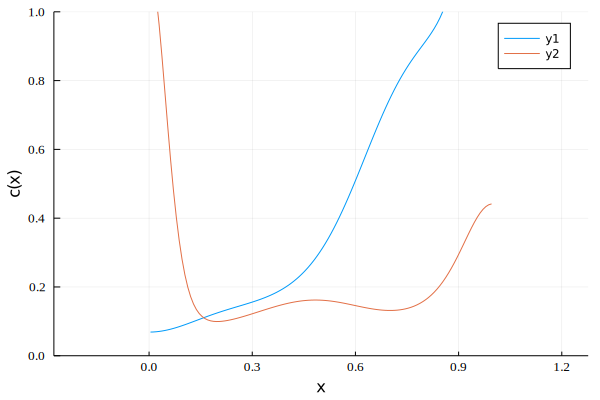

In [161]:
XX=dic["spx"]
ZZ=collect(dic["spz"][1:end-1]).+dic["spz"][2]/2
N0=getN(out,Nx,Nz)
C0=getC(out,Nx,Nz)
plot(XX,C0,aspect_ratio=:equal,ylims=(0,1),xlabel="x",ylabel="c(x)")
default(titlefont = (20, "times"), tickfont = (12.5, "times", :black))


#savefig(direct*"MAP.svg")
print(total_mass(out,Nx,Nz))
print(minimum(N0))
print(maximum(N0))
plot(ZZ,N0[:,50],aspect_ratio=:equal,ylims=(0,1),xlabel="x",ylabel="c(x)")
plot!(ZZ,N0[:,1],aspect_ratio=:equal,ylims=(0,1),xlabel="x",ylabel="c(x)")


In [155]:
dic

Dict{Any,Any} with 25 entries:
  "DC"              => Dict{Any,Any}("cmax"=>0.001,"pmax"=>0.02)
  "cN"              => 0.0125
  "hz"              => 0.00833333
  "nx"              => 50
  "cH"              => 0.3
  "Dox"             => 6.3
  "omegap"          => 1
  "max_consumption" => 25.2
  "magnVp"          => 0.0008
  "omegam"          => 2
  "epsm"            => 0.1
  "dAp"             => 0.001
  "Vm"              => [0.0, 1.66601e-5, 3.30914e-5, 4.90776e-5, 6.44258e-5, 7.…
  "Dx"              => 0.0001
  "hx"              => 0.02
  "spx"             => 0.0:0.02:1.0
  "nz"              => 120
  "CSC"             => Dict{Any,Any}("pmax"=>0.005)
  "epsp"            => 0.1
  "cinf"            => 1
  "dN"              => 0.1
  "magnVm"          => 0.0002
  "Dz"              => 5.0e-6
  "Vp"              => [0.0, 0.0831561, 0.16517, 0.244963, 0.321571, 0.39419, 0…
  "spz"             => 0.0:0.008333333333333333:1.0

In [166]:
opt_newton = NewtonPar(tol = 1e-7, verbose =false, maxIter = 4)
opts_br = ContinuationPar(dsmin=0.005,dsmax=0.5,ds=-0.01, pMin=0.5,pMax=5. ,maxSteps=400,detectBifurcation=2,
    nev = 3,  newtonOptions = opt_newton,saveSolEveryStep=2,plotEveryStep = 5,precisionStability=1e-6, 
    nInversion= 4, dsminBisection = 1e-7, maxBisectionSteps = 25);
XX=dic["spx"]
ZZ=collect(dic["spz"][1:end-1]).+dic["spz"][2]/2

br2, _ = BK.continuation(Fun,FJ,out*0.0,par_mod, (@lens _.pmax), opts_br;#,deflationOp;
    #plotSolution = (x, p; kwargs...) -> (heatmap!(XX, ZZ, getN(x,Nx,Nz); color=:viridis, label="", kwargs...);ylims!(0,1,subplot=4);xlims!(0,1,subplot=4)),
    printSolution = (x, p) -> total_mass(x,Nx,Nz),
    normC = x -> norm(x, Inf),
    plot = false,verbose= 2);
#savefig("BIfVp.svg")

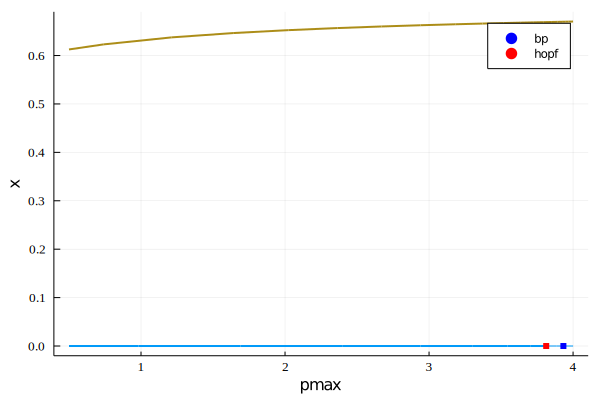

In [173]:
plot(br2)
plot!(br)

In [14]:
eig=EigArpack(0.1,:LM)

opt_newton = NewtonPar(tol = 1e-10, verbose =false, maxIter = 5,eigsolver=eig)
opts_br = ContinuationPar(dsmin=0.005,dsmax=0.1,ds=-0.01, pMin=0.0,pMax=6.0,maxSteps=300,detectBifurcation=1,
    nev = 4,  newtonOptions = opt_newton,saveSolEveryStep=1,plotEveryStep = 20,precisionStability=1e-12, 
    nInversion= 4, dsminBisection = 1e-8, maxBisectionSteps = 50);

In [15]:
XX=dic["spx"]
ZZ=collect(dic["spz"][1:end-1]).+dic["spz"][2]/2

br1, _ = BK.continuation(Fun,FJ,out,par_mod, (@lens _.Gmax), opts_br;#,deflationOp;
    plotSolution = (x, p; kwargs...) -> (heatmap!(XX, ZZ, getN(x,Nx,Nz); color=:viridis, label="", kwargs...);ylims!(0,1,subplot=4);xlims!(0,1,subplot=4)),
    printSolution = (x, p) -> total_mass(x,Nx,Nz),
    normC = x -> norm(x, Inf),
    plot = true);
#savefig("BIfVp.svg")

MethodError: [91mMethodError: no method matching plotBranchCont(::ContResult{NamedTuple{(:x, :param, :itnewton, :itlinear, :ds, :theta, :n_unstable, :n_imag, :stable, :step),Tuple{Float64,Float64,Int64,Int64,Float64,Float64,Int64,Int64,Bool,Int64}},Array{Complex{Float64},1},Array{Complex{Float64},2},BifurcationKit.SpecialPoint{Float64,NamedTuple{(:x,),Tuple{Float64}},Array{Float64,1}},Array{NamedTuple{(:x, :p, :step),Tuple{Array{Float64,1},Float64,Int64}},1},Nothing,NamedTuple{(:pmax, :Gmax, :vp, :OpDzz, :OpDxx, :OpDox, :par),Tuple{Float64,Float64,Float64,SparseMatrixCSC{Float64,Int64},SparseMatrixCSC{Float64,Int64},SparseMatrixCSC{Float64,Int64},Dict{Any,Any}}},Setfield.PropertyLens{:Gmax}}, ::BorderedArray{Array{Float64,1},Float64}, ::ContinuationPar{Float64,DefaultLS,EigArpack{Float64,typeof(real),Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}}}, ::var"#10#14")[39m
[91m[0mClosest candidates are:[39m
[91m[0m  plotBranchCont(::ContResult, [91m::BifurcationKit.AbstractContinuationState[39m, [91m::ContIterable[39m) at /home/celora/.julia/packages/BifurcationKit/Yvq7p/src/Continuation.jl:215[39m

In [ ]:
indfold = 2
optcontfold = ContinuationPar(dsmin = 0.001, dsmax = 0.05, ds= 0.01, pMax = 20.0, pMin = 1.,maxSteps = 20,plotEveryStep = 5)

outfoldco, = continuationFold(Fun,FJ,br1, indfold,(@lens _.Gmax), optcontfold;
plot = true, verbosity = 2)
scene = plot(outfoldco, plotfold=true, legend = :bottomright)

In [44]:
direct="solBif"
parvec= Vector{Float64}()
val= Vector{Float64}()
stabvec=br1.stable[1:end]

for el in br1.sol
    append!(parvec,el.p)
    append!(val,total_mass(el.x,Nx,Nz))
end
M=hcat(parvec,val,stabvec);
using DelimitedFiles
open(direct*"/bifdiagVp8.txt", "w") do io
           writedlm(io, M, ',')
end;


In [25]:
using LaTeXStrings
default(titlefont = (20, "times"), tickfont = (12.5, "times", :black))

plot!(br2)
plot(br1)


UndefVarError: [91mUndefVarError: br2 not defined[39m

In [48]:
using LaTeXStrings
default(titlefont = (20, "times"), tickfont = (14, "times", :black))

plot(par,oxmin,xlim=(0,10),ylim=(0,0.32),legend=false,xlabel=L"$\gamma_{max}$",ylabel=L"$\min_x \ c\,(x)$",
    labelfontsize= 15,grid =false,linewidth=2)
plot!(0:1:10,0.025*ones(11,1),linestyle = :dashdot,linewidth=1.5)
plot!(0:1:10,0.3*ones(11,1),linestyle = :dashdot,linewidth=1.5)
savefig("Minimum_ox.svg")

In [6]:
sol0[1:end-Nx-1].= 0.0;
sol0[end-Nx:end].= 1.0;
eig=EigArpack(0.1,:LM)

EigArpack{Float64,typeof(real),Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}}(0.1, :LM, real, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}())

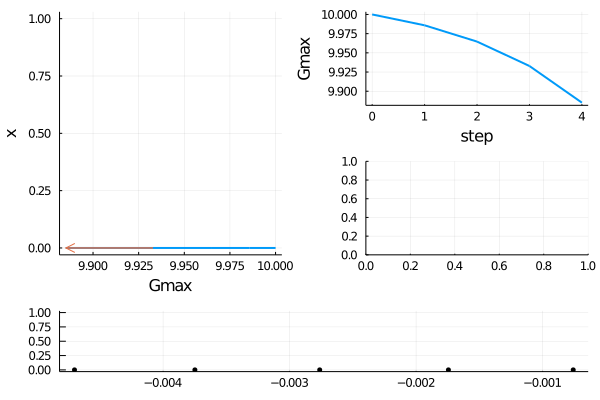

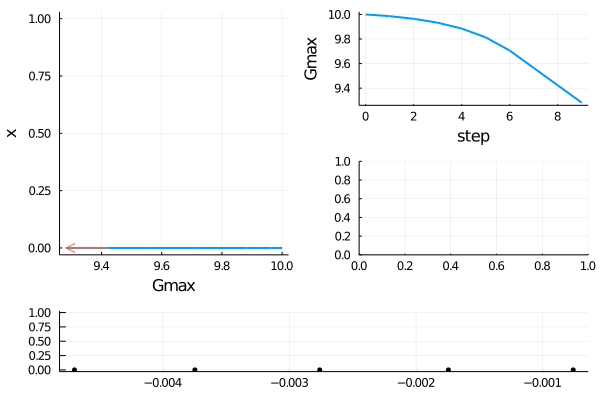

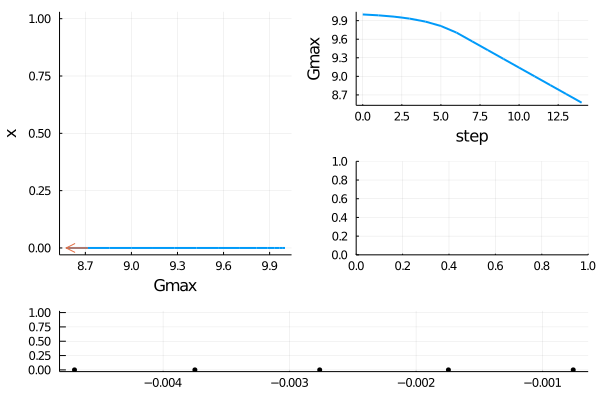

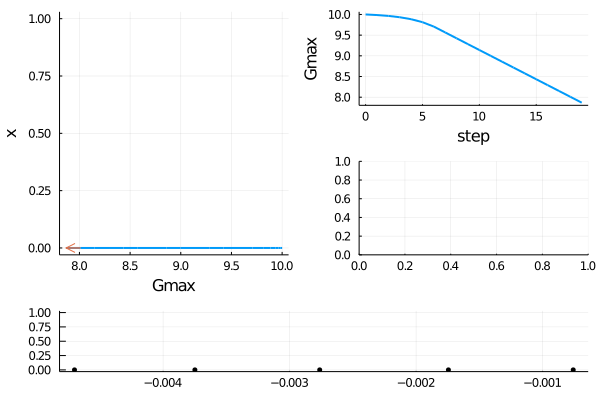

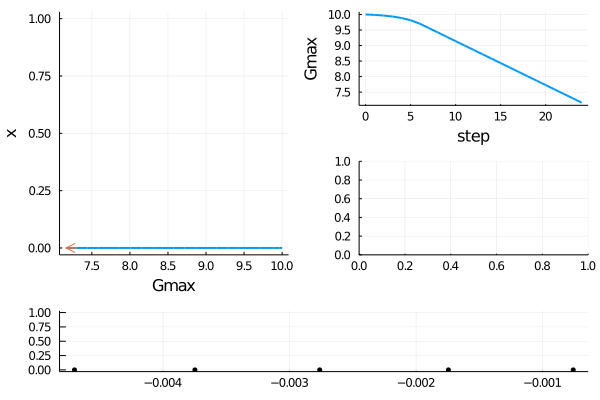

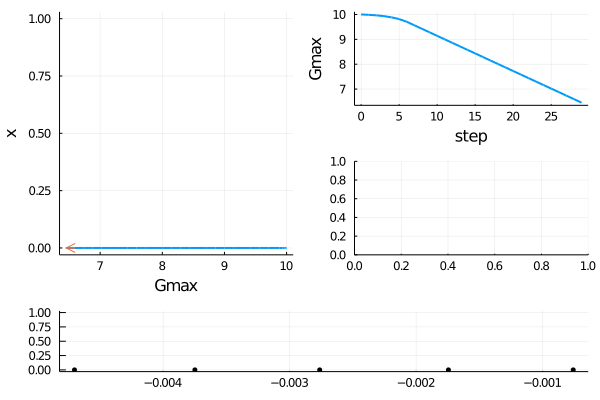

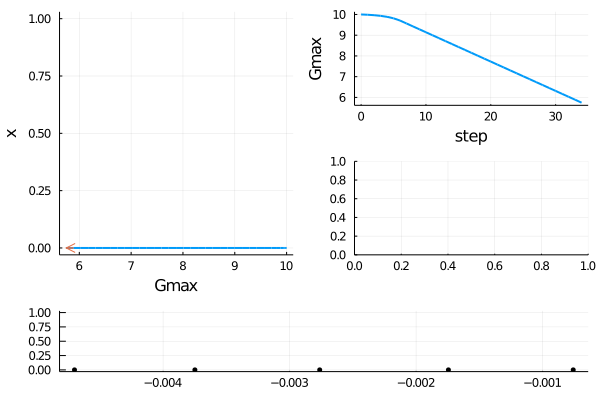

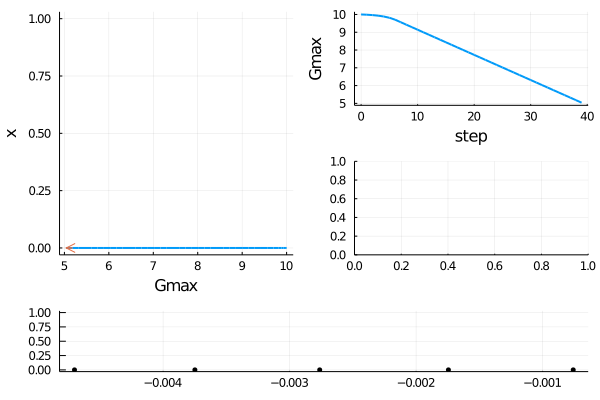

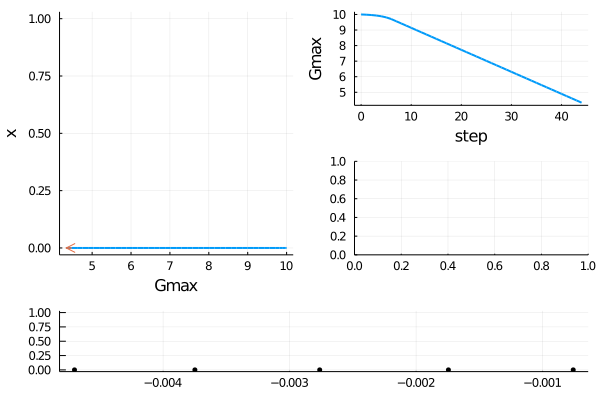

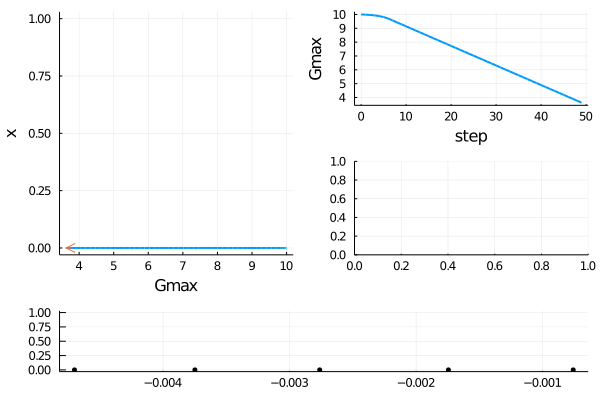

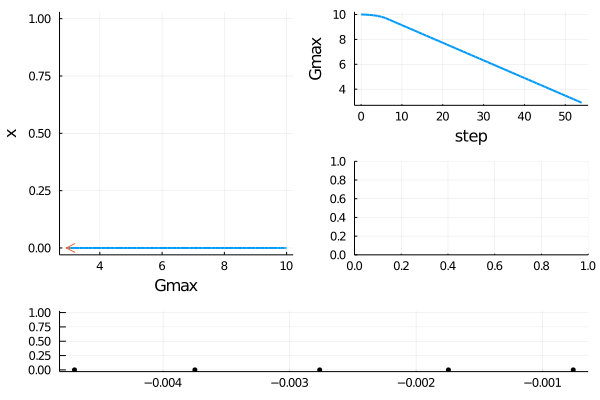

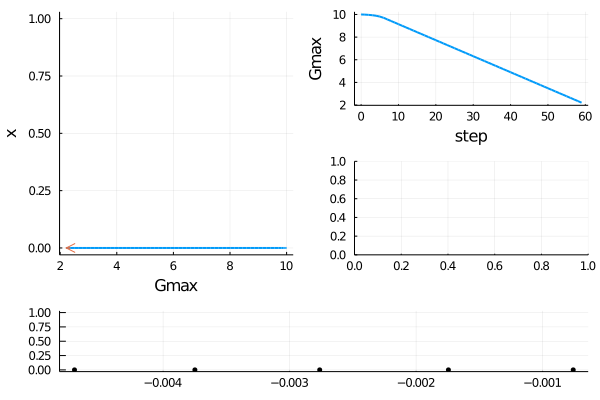

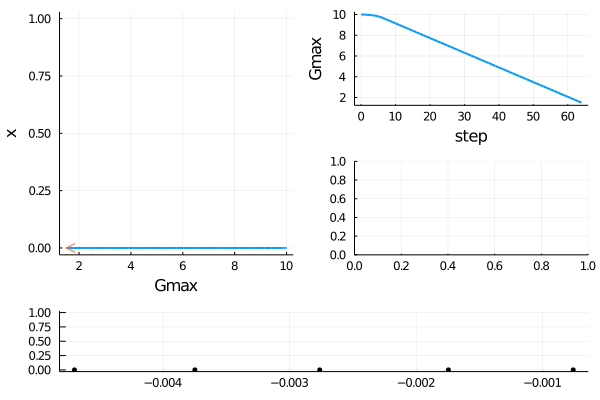

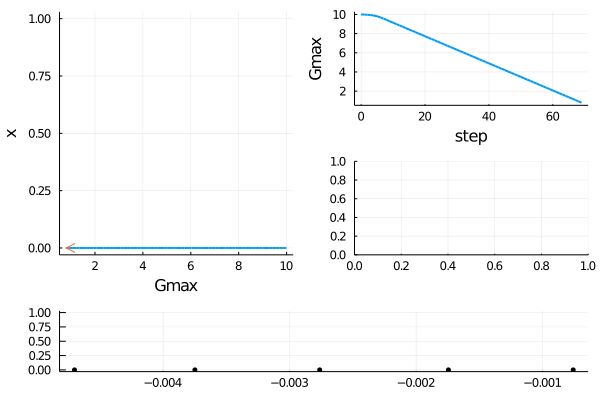

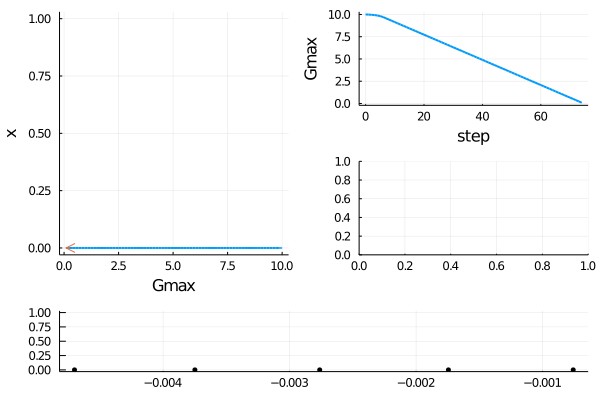

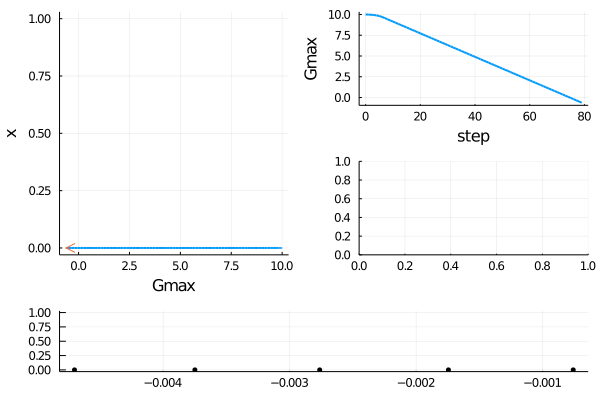

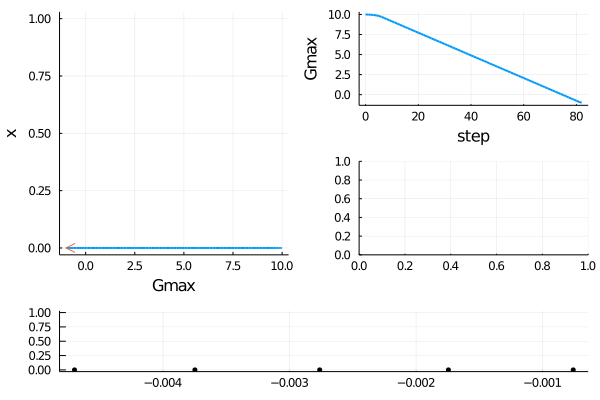

In [7]:
opt_newton = NewtonPar(tol = 1e-8, verbose =false, maxIter = 50,eigsolver=eig)

opts_br = ContinuationPar(dsmin=0.005,dsmax=0.05,ds=-0.01, pMax=10.0 ,maxSteps=100,detectBifurcation=3,
    nev = 3,  newtonOptions = opt_newton,plotEveryStep = 5,precisionStability=1e-6, 
    nInversion= 4, dsminBisection = 1e-7, maxBisectionSteps = 25);

br1, _ = BK.continuation(Fun,FJ,sol0,par_mod, (@lens _.Gmax), opts_br;
  #  plotSolution = (x, p; kwargs...) -> (heatmap!(XX, ZZ, getN(x,Nx,Nz); color=:viridis, label="", kwargs...);ylims!(0,1,subplot=4);xlims!(0,1,subplot=4)),
    printSolution = (x, p) -> total_mass(x,Nx,Nz),
 #   normC = x -> norm(x, Inf),
    plot = true,  filename="bif1");

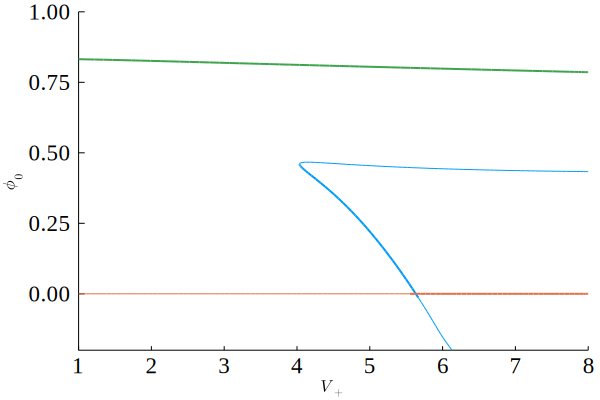

In [82]:
using LaTeXStrings
default(titlefont = (20, "times"), tickfont = (14, "times", :black))
plot(br3,ylim=(-0.2,1.0),grid=false,xlabel=L"$V_{+}$",ylabel=L"$\phi_0$")
plot!(br1)
display(plot!(br2,xlabel=L"$V_{+}$",ylabel=L"$\phi_0$",xlim=(1,8)))
savefig("diagV.svg")

In [64]:
dic["magnVp"]=8e-4
par_mod = (vp =0.1, OpDzz=OpD1, OpDxx = OpD2, OpDox=OpD3,par = dic);

opt_newton = NewtonPar(tol = 1e-7, verbose = true, maxIter = 50)
out, _, _ = @time BK.newton(FunDx,FJDx,sol0, par_mod, opt_newton);


 Newton Iterations      f(x)      Linear Iterations

          0          1.7956e+01             0
          1          9.2015e+00             1
          2          2.7980e+00             1
          3          1.5396e+00             1
          4          1.1864e+01             1
          5          3.3839e+00             1
          6          6.5040e-01             1
          7          3.7973e-01             1
          8          3.0183e-02             1
          9          6.3004e-03             1
         10          1.2204e-03             1
         11          8.8700e-05             1
         12          5.5880e-07             1
         13          2.4233e-11             1
  7.394426 seconds (5.97 M allocations: 3.234 GiB, 7.16% gc time)


Changing the diffusion coefficient with constant velocity Vp=8e-4 for which in the well-mixed scenario the system is unstable

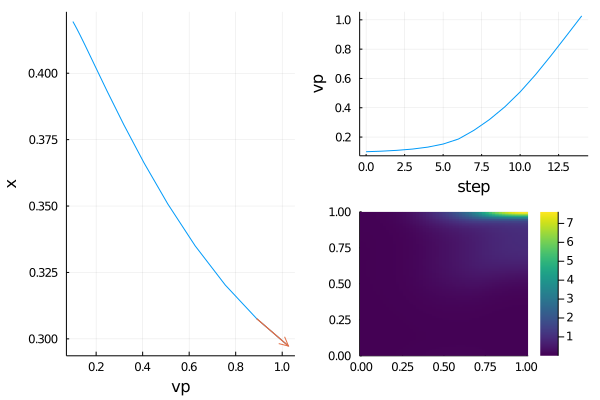

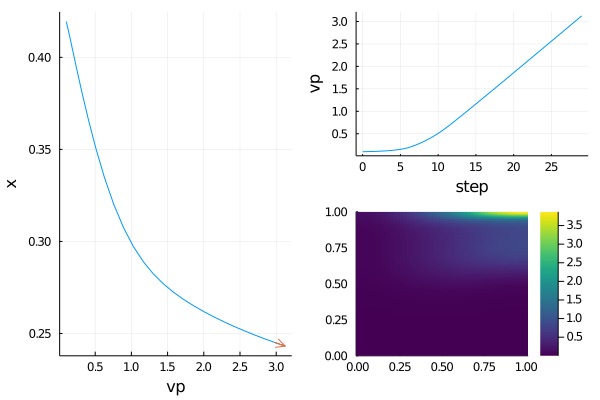

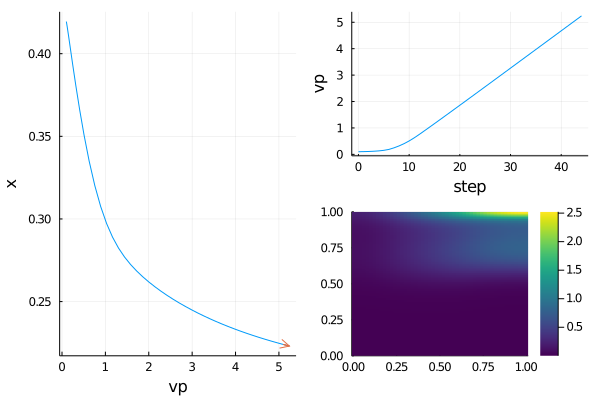

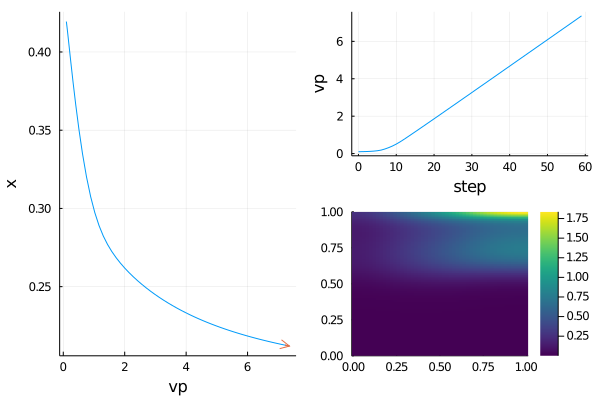

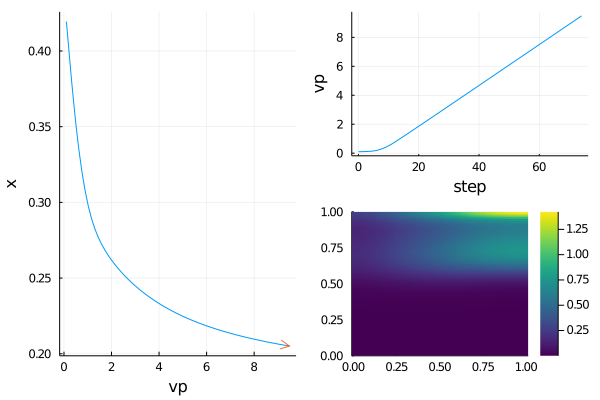

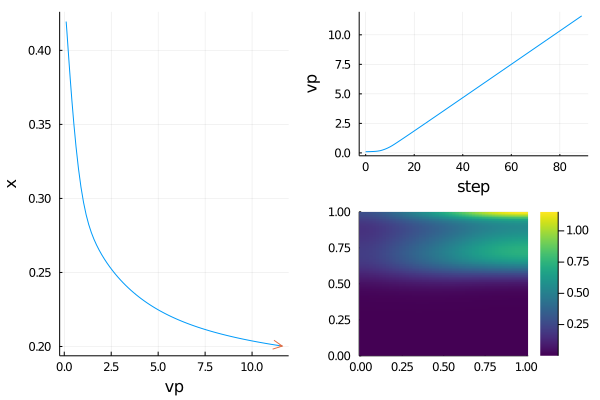

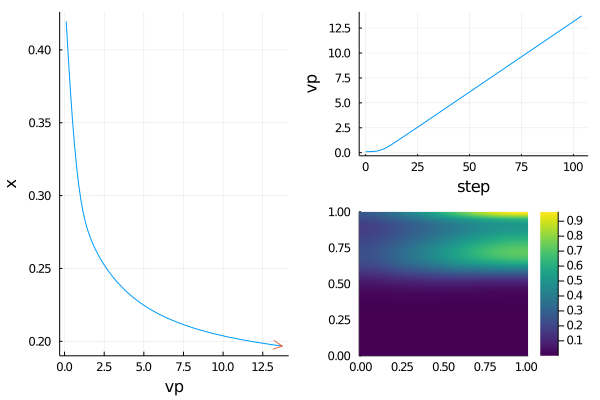

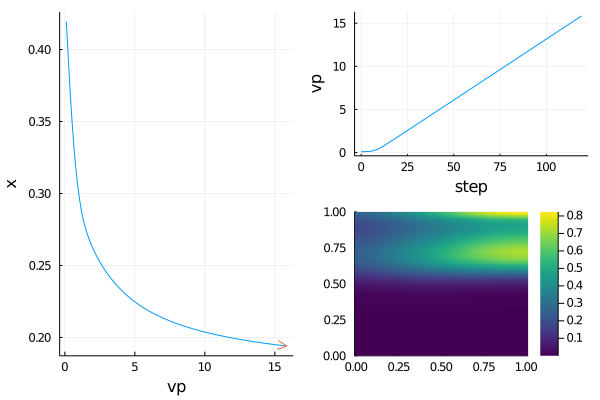

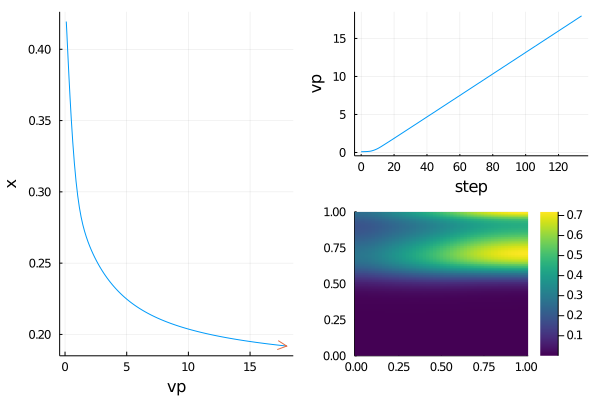

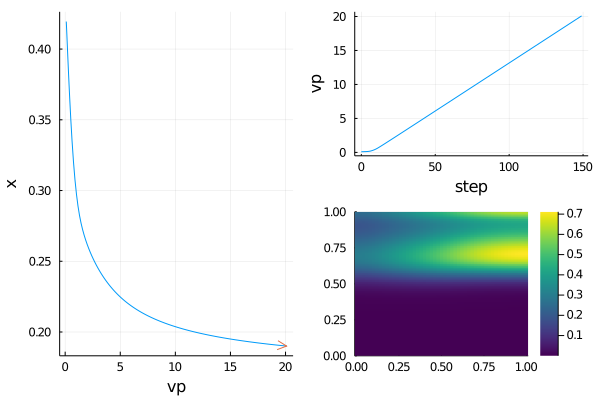

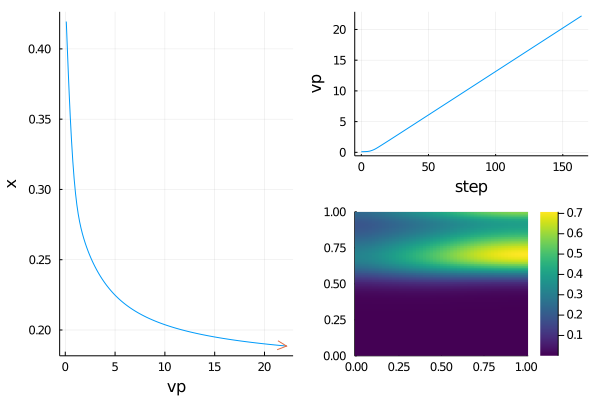

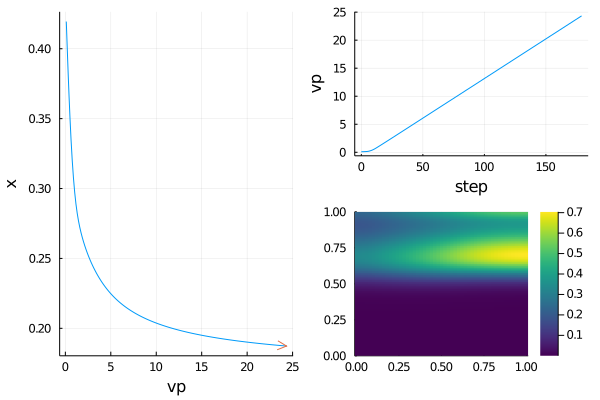

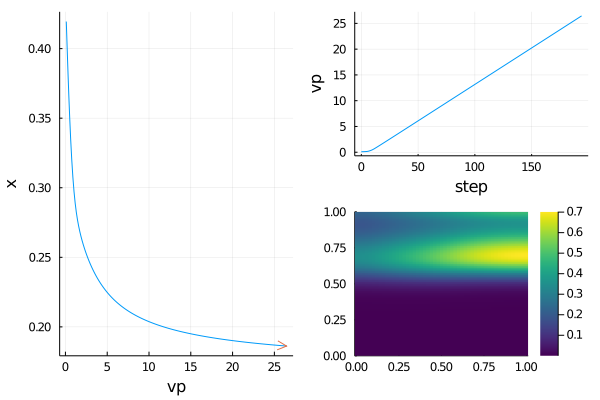

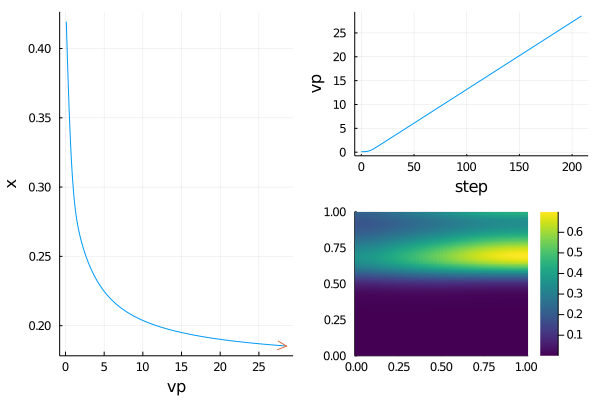

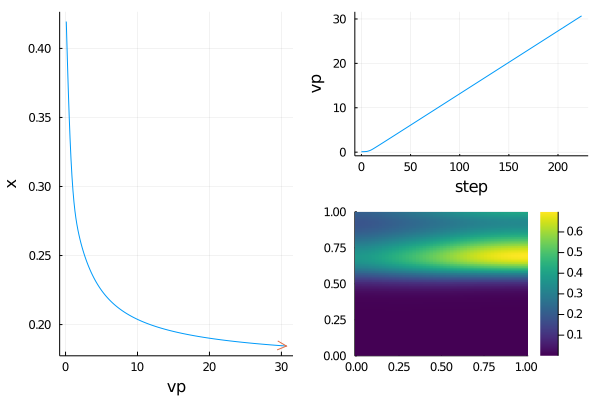

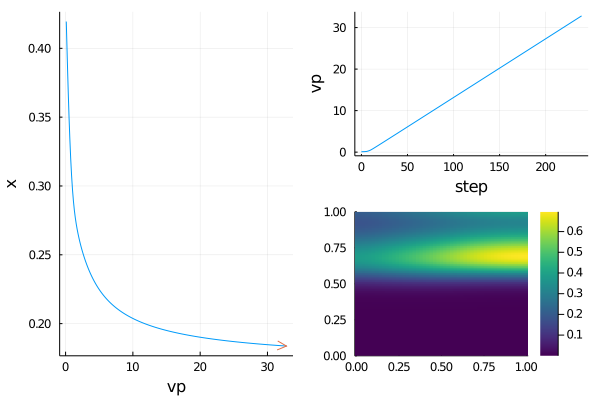

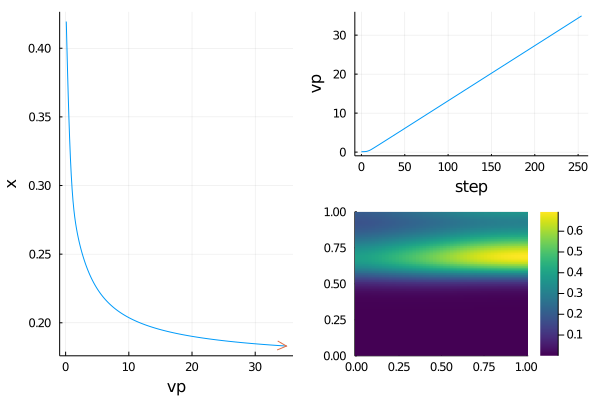

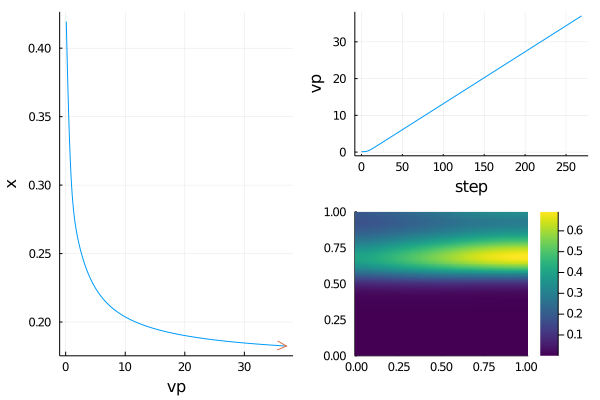

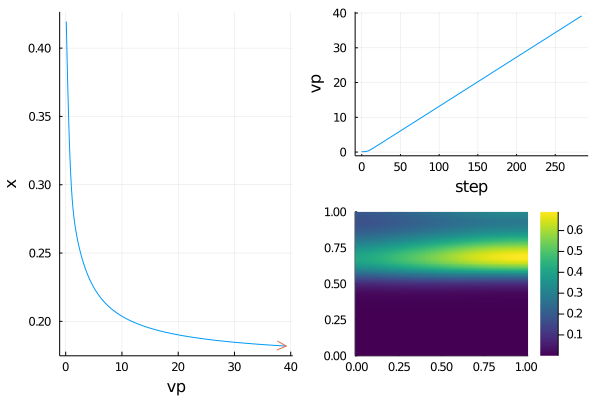

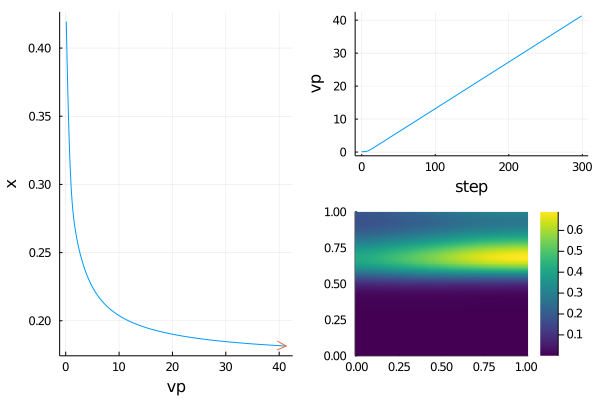

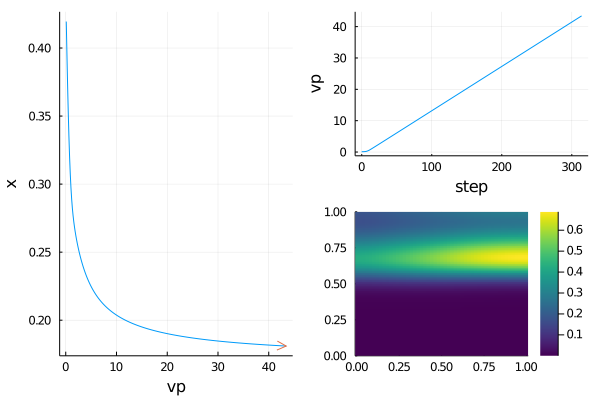

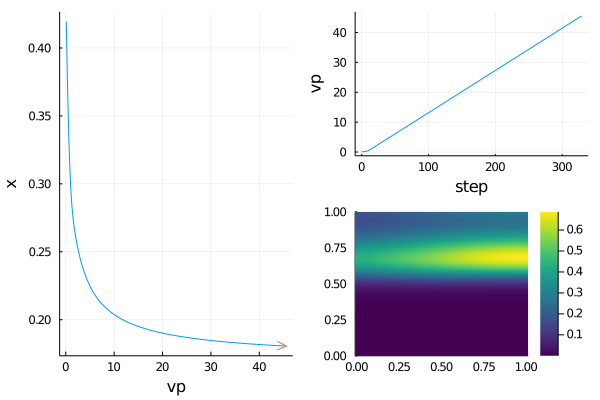

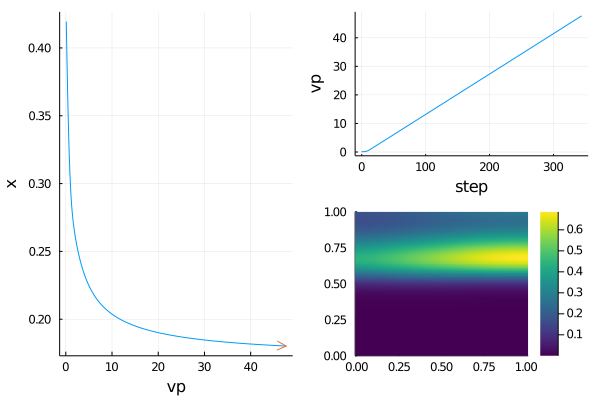

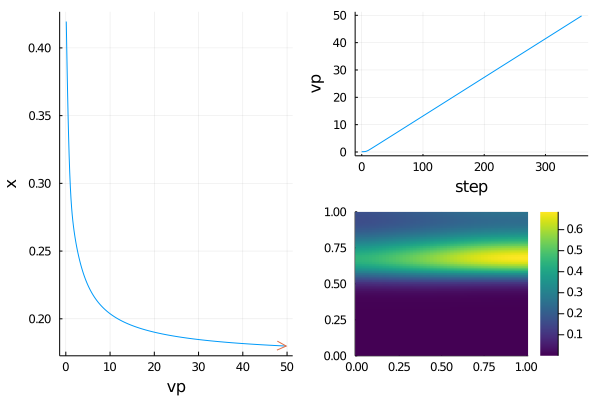

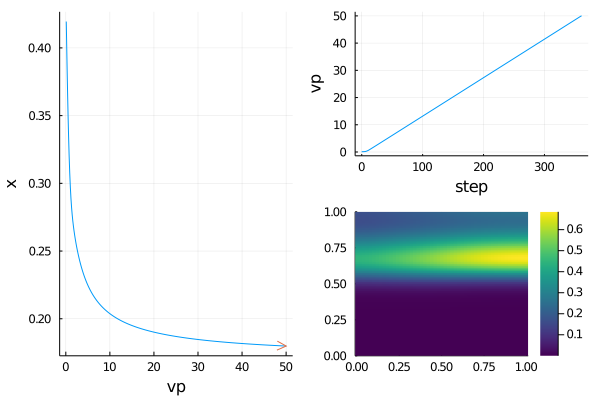

In [65]:
#dic["magnVp"]=8e-4
par_mod = (vp =1.0, OpDzz=OpD1, OpDxx = OpD2, OpDox=OpD3,par = dic);

opt_newton = NewtonPar(tol = 1e-8, verbose =false, maxIter = 50)
opts_br = ContinuationPar(dsmin=0.01,dsmax=0.1,ds=0.01, pMax=50.0 ,maxSteps=1000,detectBifurcation=0,
    nev = 2,  newtonOptions = opt_newton,plotEveryStep = 15,precisionStability=1e-6, 
    nInversion= 4, dsminBisection = 1e-7, maxBisectionSteps = 25);
#par_mod = (Gmax =0.0, OpDzz=OpD1, OpDxx = OpD2, OpDox=OpD3,par = dic);

br2, _ = BK.continuation(FunDx,FJDx,out,par_mod, (@lens _.vp), opts_br;
    plotSolution = (x, p; kwargs...) -> (heatmap!(XX, ZZ, getN(x,Nx,Nz); color=:viridis, label="", kwargs...);ylims!(0,1,subplot=4);xlims!(0,1,subplot=4)),
    printSolution = (x, p) -> total_mass(x,Nx,Nz),
    normC = x -> norm(x, Inf),
    plot = true,  filename="bif1");

savefig("BIfDx.svg")



In [93]:
mass[1]

0.3005264814463716

In [94]:
dic["Dx"]

0.0001

In [181]:
A=[1,2,3]
append!(A,[4])

4-element Array{Int64,1}:
 1
 2
 3
 4

In [183]:
A[1:end-1]


3-element Array{Int64,1}:
 1
 2
 3

In [219]:
dot(outA-out1,outA-out1)

15.66608840008295